# Alpha Beta KNN Prediction
Up to now, I've used standard imputation methods, which are for general cases. However, we have a specific imputation case: either alpha or beta is missing entirely. So we can train a model to predict the alpha rows based on the beta rows and vice versa.

Let's start by taking a look at the possible missing combinations.

In [1]:
from util import get_train_dataset, get_features
from sklearn.model_selection import train_test_split

df = get_train_dataset()
df, df_test = train_test_split(df, test_size=0.2, random_state=42)
df.head()

,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ,reaction,TRAJ_family,TRAJ_version,TRAV_family,TRAV_version,TRBV_family,TRBV_version,TRBJ_family,TRBJ_version
2580,CAGGGSQGNLIF,TRAV27,TRAJ42,CASSTRSAYEQYF,TRBV19,TRBJ2-7,1,TRAJ42,1.0,TRAV27,1,TRBV19,1.0,TRBJ2,7.0
478,NaN,NaN,NaN,CASSLMEGHTEAFF,TRBV27,TRBJ1-1,0,NaN,NaN,NaN,NaN,TRBV27,1.0,TRBJ1,1.0
1352,CAPEGGQNFVF,TRAV13-1,TRAJ26,CASSIRSGETQYF,TRBV19,TRBJ2-5,1,TRAJ26,1.0,TRAV13,1,TRBV19,1.0,TRBJ2,5.0
3322,CALSEMVNARLMF,TRAV19,TRAJ31,CASSIGASGSRETQYF,TRBV19,TRBJ2-5,0,TRAJ31,1.0,TRAV19,1,TRBV19,1.0,TRBJ2,5.0
7396,CASVGMDSSYKLIF,TRAV12-2,TRAJ12,CASSTRSGTEAFF,TRBV19,TRBJ1-1,1,TRAJ12,1.0,TRAV12,2,TRBV19,1.0,TRBJ1,1.0


In [2]:
# Either alpha is missing, which means CDR3_alfa, TRAV and TRAJ (and there family and version) are missing
df[df['CDR3_alfa'].isna()].head()

,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ,reaction,TRAJ_family,TRAJ_version,TRAV_family,TRAV_version,TRBV_family,TRBV_version,TRBJ_family,TRBJ_version
478,NaN,NaN,NaN,CASSLMEGHTEAFF,TRBV27,TRBJ1-1,0,NaN,NaN,NaN,NaN,TRBV27,1.0,TRBJ1,1.0
7059,NaN,NaN,NaN,CSVERSGVQTDTQYF,TRBV29-1,TRBJ2-3,1,NaN,NaN,NaN,NaN,TRBV29,1.0,TRBJ2,3.0
4871,NaN,NaN,NaN,CASSGPSGTGLDSPLHF,TRBV6-1,TRBJ1-6,0,NaN,NaN,NaN,NaN,TRBV6,1.0,TRBJ1,6.0
7962,NaN,NaN,NaN,CASSAGQHNYEQYF,TRBV5-5,TRBJ2-7,0,NaN,NaN,NaN,NaN,TRBV5,5.0,TRBJ2,7.0
1033,NaN,NaN,NaN,CASSINSGWGEQFF,TRBV19,TRBJ2-1,1,NaN,NaN,NaN,NaN,TRBV19,1.0,TRBJ2,1.0


In [3]:
# Or beta is missing, which means CDR3_beta, TRBV and TRBJ (and there family and version) are missing
df[df['CDR3_beta'].isna()].head()

,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ,reaction,TRAJ_family,TRAJ_version,TRAV_family,TRAV_version,TRBV_family,TRBV_version,TRBJ_family,TRBJ_version
3995,CIVENNDMRF,TRAV26-1,TRAJ43,NaN,NaN,NaN,0,TRAJ43,1.0,TRAV26,1,NaN,NaN,NaN,NaN
1325,CAASEGRGGYNKLIF,TRAV29DV5,TRAJ4,NaN,NaN,NaN,0,TRAJ4,1.0,TRAV29DV5,1,NaN,NaN,NaN,NaN
7777,CAMSGDGGSQGNLIF,TRAV12-3,TRAJ42,NaN,NaN,NaN,1,TRAJ42,1.0,TRAV12,3,NaN,NaN,NaN,NaN


In [4]:
# both missing should not happen
df[df['CDR3_alfa'].isna() & df['CDR3_beta'].isna()].head()

,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ,reaction,TRAJ_family,TRAJ_version,TRAV_family,TRAV_version,TRBV_family,TRBV_version,TRBJ_family,TRBJ_version


In [5]:
from util import get_baseline_sequence_features, update_alpha_or_beta
import pandas as pd


def get_features(df, test=False, chains=None):
    df_num_rows = df.shape[0]

    chains = {"alfa": 'A', "beta": 'B'} if chains is None else chains

    all_chains_features = []
    for chain in chains:
        update_alpha_or_beta(chain)

        short = chains[chain]
        rename_map = {f"CDR3_{chain}": "CDR3",
                      f"TR{short}V": "V",
                      f"TR{short}J": "J",
                      f"TR{short}V_family": "V_family",
                      f"TR{short}J_family": "J_family",
                      f"TR{short}V_version": "V_version",
                      f"TR{short}J_version": "J_version"}
        renamed = df[rename_map.keys()].rename(columns=rename_map)

        chain_features = get_baseline_sequence_features(renamed, test).add_prefix(f'{chain}_')

        all_chains_features.append(chain_features)

        chain_features_num_rows = chain_features.shape[0]

        assert df_num_rows == chain_features_num_rows, f"Number of rows in df ({df_num_rows}) and chain_features ({chain_features_num_rows}) must be the same"

    update_alpha_or_beta(None)

    return pd.concat(all_chains_features, axis=1)


We might try to predict the missing values immediately based on those strings. However, we'll create features from this, which might introduce new missing values and the numbers of the features are often more useful to create features than strings. Let's take a look at where the missing values in the features are.

In [6]:
# Case 1: alpha not missing
df_alpha_not_missing = df[df['CDR3_alfa'].notna()]
x = get_features(df_alpha_not_missing, chains={"alfa": 'A'})
x.head()

,alfa_J=TRAJ10,alfa_J=TRAJ11,alfa_J=TRAJ12,alfa_J=TRAJ13,alfa_J=TRAJ15,alfa_J=TRAJ16,alfa_J=TRAJ17,alfa_J=TRAJ18,alfa_J=TRAJ20,alfa_J=TRAJ21,...,alfa_pos_-8_pI,alfa_pos_8_pI,alfa_pos_-9_pI,alfa_pos_9_pI,alfa_pos_-11_pI,alfa_pos_-10_pI,alfa_pos_10_pI,alfa_pos_11_pI,alfa_pos_-12_pI,alfa_pos_12_pI
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In previous versions, the positional features and amino counts might contained NaNs, but it makes more sense to just set them to 0, so I did that. Also the positionalf features (e.g. 'alfpha_pos_2') where set to zero. TOASK whether this is a correct approach.

In [15]:
df_both_alpha_and_beta = df[df['CDR3_alfa'].notna() & df['CDR3_beta'].notna()]
features_complete_samples = get_features(df_both_alpha_and_beta)
features_complete_samples.head()

,alfa_J=TRAJ10,alfa_J=TRAJ11,alfa_J=TRAJ12,alfa_J=TRAJ13,alfa_J=TRAJ15,alfa_J=TRAJ16,alfa_J=TRAJ17,alfa_J=TRAJ18,alfa_J=TRAJ20,alfa_J=TRAJ21,...,beta_pos_-8_pI,beta_pos_-7_pI,beta_pos_7_pI,beta_pos_8_pI,beta_pos_-9_pI,beta_pos_9_pI,beta_pos_-10_pI,beta_pos_10_pI,beta_pos_-11_pI,beta_pos_11_pI
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.253418,6.012207,5.937012,6.012207,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
from util import get_columns_starting_with

alfa_rows = get_columns_starting_with(features_complete_samples, 'alfa_')
beta_rows = get_columns_starting_with(features_complete_samples, 'beta_')

In [22]:
# Take a sample from df where alpha is missing
df_alpha_missing = df[df['CDR3_alfa'].isna()]
sample = df_alpha_missing.head(1)
sample

,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ,reaction,TRAJ_family,TRAJ_version,TRAV_family,TRAV_version,TRBV_family,TRBV_version,TRBJ_family,TRBJ_version
478,NaN,NaN,NaN,CASSLMEGHTEAFF,TRBV27,TRBJ1-1,0,NaN,NaN,NaN,NaN,TRBV27,1.0,TRBJ1,1.0


In [23]:
sample_features = get_features(sample)
sample_features

,alfa_J,alfa_V,alfa_CDR3_length,alfa_basicity,alfa_hydrophobicity,alfa_helicity,alfa_mutation_stability,alfa_peptide_mass,alfa_pi,alfa_pos_0_A,...,beta_pos_-3_pI,beta_pos_-2_pI,beta_pos_-1_pI,beta_pos_1_pI,beta_pos_2_pI,beta_pos_3_pI,beta_pos_4_pI,beta_pos_5_pI,beta_pos_6_pI,beta_pos_7_pI
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,6.012207,6.012207,3.29834,6.012207,7.844238,6.012207,3.29834,6.012207,6.012207,6.012207


In [24]:
from util import get_columns_starting_with

beta_rows_sample = get_columns_starting_with(sample_features, 'beta_')
beta_rows_sample

,beta_J=TRBJ1-1,beta_V=TRBV27,beta_CDR3_length,beta_C_count,beta_A_count,beta_S_count,beta_L_count,beta_M_count,beta_E_count,beta_G_count,...,beta_pos_-3_pI,beta_pos_-2_pI,beta_pos_-1_pI,beta_pos_1_pI,beta_pos_2_pI,beta_pos_3_pI,beta_pos_4_pI,beta_pos_5_pI,beta_pos_6_pI,beta_pos_7_pI
0,1.0,1.0,14,1,2,2,1,1,2,1,...,6.012207,6.012207,3.29834,6.012207,7.844238,6.012207,3.29834,6.012207,6.012207,6.012207


In [ ]:
# Find the closest match in df_both_alpha_and_beta
current_row = beta_rows_sample

# find the 5 closest rows in beta_rows
# get the columns both current_row and beta_rows have in common

common_columns = current_row.columns.intersection(beta_rows.columns)

current_row_common = current_row[common_columns]
beta_rows_common = beta_rows[common_columns]

In [27]:
current_row_common

,beta_J=TRBJ1-1,beta_V=TRBV27,beta_CDR3_length,beta_C_count,beta_A_count,beta_S_count,beta_L_count,beta_M_count,beta_E_count,beta_G_count,...,beta_pos_-3_pI,beta_pos_-2_pI,beta_pos_-1_pI,beta_pos_1_pI,beta_pos_2_pI,beta_pos_3_pI,beta_pos_4_pI,beta_pos_5_pI,beta_pos_6_pI,beta_pos_7_pI
0,1.0,1.0,14,1,2,2,1,1,2,1,...,6.012207,6.012207,3.29834,6.012207,7.844238,6.012207,3.29834,6.012207,6.012207,6.012207


In [28]:
beta_rows_common.head()

,beta_J=TRBJ1-1,beta_V=TRBV27,beta_CDR3_length,beta_C_count,beta_A_count,beta_S_count,beta_L_count,beta_M_count,beta_E_count,beta_G_count,...,beta_pos_-3_pI,beta_pos_-2_pI,beta_pos_-1_pI,beta_pos_1_pI,beta_pos_2_pI,beta_pos_3_pI,beta_pos_4_pI,beta_pos_5_pI,beta_pos_6_pI,beta_pos_7_pI
0,0.0,0.0,13,1,2.0,3.0,0.0,0.0,1.0,0.0,...,6.012207,6.012207,11.084473,6.012207,5.937012,3.298340,6.012207,5.937012,6.012207,0.000000
1,0.0,0.0,13,1,1.0,3.0,0.0,0.0,1.0,1.0,...,6.012207,6.012207,11.084473,6.012207,3.298340,6.012207,6.012207,5.937012,6.012207,0.000000
2,0.0,0.0,16,1,2.0,4.0,0.0,0.0,1.0,2.0,...,6.012207,6.012207,6.012207,6.012207,6.012207,11.084473,3.298340,6.012207,6.012207,5.937012
3,1.0,0.0,13,1,2.0,3.0,0.0,0.0,1.0,1.0,...,6.012207,6.012207,11.084473,6.012207,6.012207,3.298340,6.012207,6.012207,6.012207,0.000000
4,0.0,0.0,13,1,2.0,2.0,0.0,0.0,2.0,0.0,...,6.012207,6.012207,3.298340,6.012207,5.937012,3.298340,6.012207,5.937012,6.012207,0.000000


In [30]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

# https://stackoverflow.com/questions/59013965/efficient-k-nearest-neighbor-of-all-pairs-in-a-pandas-dataframe
# using auto algorithm instead of ball-tree (since it's the default)
nbrs = NearestNeighbors(n_neighbors=5).fit(beta_rows_common)
row_nbrs = nbrs.kneighbors(current_row_common)
row_nbrs

(array([[22.77946845, 28.83431731, 28.88576777, 29.69742479, 30.19635712]]),
 array([[1450,  675, 1403, 1113, 2507]], dtype=int64))

In [34]:
# get the indices from the features_complete_samples dataframe
corresponding_rows = features_complete_samples.iloc[row_nbrs[1][0]]
corresponding_rows

,alfa_J=TRAJ10,alfa_J=TRAJ11,alfa_J=TRAJ12,alfa_J=TRAJ13,alfa_J=TRAJ15,alfa_J=TRAJ16,alfa_J=TRAJ17,alfa_J=TRAJ18,alfa_J=TRAJ20,alfa_J=TRAJ21,...,beta_pos_-8_pI,beta_pos_-7_pI,beta_pos_7_pI,beta_pos_8_pI,beta_pos_-9_pI,beta_pos_9_pI,beta_pos_-10_pI,beta_pos_10_pI,beta_pos_-11_pI,beta_pos_11_pI
1450,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.253418,6.012207,0.0,0.0,0.0,0.0,0.0,0.0,0.0
675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.253418,6.012207,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.253418,6.012207,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.253418,6.012207,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.253418,6.012207,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
corresponding_alfa_rows = alfa_rows.iloc[row_nbrs[1][0]]
# get the mean of the corresponding rows
corresponding_alfa_rows.mean()

NameError: name 'alfa_rows' is not defined

# General approach
This was just for one specific row. Now use this to fill in all missing values in df_test.

In [59]:
from util import get_train_dataset, get_features, fix_test, get_columns_starting_with
from sklearn.model_selection import train_test_split

# Create a seperate train and test dataset
# The train set will be used to search the nearest neighbors in and get values to fill in based on
# df = get_train_dataset().sample(200)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_train_y = df_train['reaction']
df_test_y = df_test['reaction']

df_train_x = get_features(df_train)
df_test_x = get_features(df_test, test=True)
df_test_x = fix_test(df_test_x, df_train_x.columns)

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


In [60]:
from sklearn.neighbors import NearestNeighbors

# filter df_test to contain only rows where alpha is missing (for debugging purposes)
# df_test = df_test[df_test['CDR3_alfa'].isna()]

# Get all complete values (to find the nearest neighbors in and get missing values from)
df_both_alpha_and_beta = df_train[df_train['CDR3_alfa'].notna() & df['CDR3_beta'].notna()]
# Convert to features
features_complete_samples = get_features(df_both_alpha_and_beta)
# Split alfa and beta rows (since we'll use one of them for searching neigbors,the other for values to fill in) (indices must remain the same, so we can still get the rows with values to fill in corresponding our search)
alfa_rows = get_columns_starting_with(features_complete_samples, 'alfa_')
beta_rows = get_columns_starting_with(features_complete_samples, 'beta_')


def get_nnbrs_parameters(df_features, full=True):
    # Get features for the test dataset
    # df_features = get_features(df)

    # splitting them only to get the common columns
    alfa_rows_test = get_columns_starting_with(df_features, 'alfa_')
    beta_rows_test = get_columns_starting_with(df_features, 'beta_')

    # get common columns of both test and train
    common_columns_alfa = alfa_rows.columns.intersection(alfa_rows_test.columns)
    common_columns_beta = beta_rows.columns.intersection(beta_rows_test.columns)

    if not full:
        return None, None, common_columns_alfa, common_columns_beta

    # We're going to search the neighbors in the common columns
    alfa_search_space = alfa_rows[common_columns_alfa]
    beta_search_space = beta_rows[common_columns_beta]

    nnbrs_alfa = NearestNeighbors(n_neighbors=5).fit(alfa_search_space)
    nnbrs_beta = NearestNeighbors(n_neighbors=5).fit(beta_search_space)

    return nnbrs_alfa, nnbrs_beta, common_columns_alfa, common_columns_beta

C:\Users\arnod\AppData\Local\Temp/ipykernel_17524/4033798687.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_both_alpha_and_beta = df_train[df_train['CDR3_alfa'].notna() & df['CDR3_beta'].notna()]


## KNN per chain
In this approach, we try to predict the missing chain based on the other chain (by using knn).

In [61]:
import numpy as np
from tqdm import tqdm


def knn_fill_df(df, nnbrs_alfa, nnbrs_beta, alfa_rows, beta_rows, common_columns_alfa, common_columns_beta):
    """"
    get_features should already be applied to df
    """
    output_df = df.copy()

    # replace the missing values with the mean of the closest rows
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc='Removing missing values'):
        is_alfa_missing = np.isnan(row['alfa_CDR3_length'])  # isinstance(row['alfa_CDR3_length'], np.float) and \
        is_beta_missing = np.isnan(row['beta_CDR3_length'])

        assert not (is_alfa_missing and is_beta_missing), "Both alpha and beta are missing"

        if is_alfa_missing:
            # print("alfa missing")
            nnbrs_model = nnbrs_beta
            common_columns = common_columns_beta
            mean_space = alfa_rows
            columns_to_fill = common_columns_alfa
        elif is_beta_missing:
            # print("beta missing")
            nnbrs_model = nnbrs_alfa
            common_columns = common_columns_alfa
            mean_space = beta_rows
            columns_to_fill = common_columns_beta
        else:
            # print("both present")
            continue

        # reshape (1, -1) because the model expects a 2d array to indicate it's one sample ((-1, 1) would mean one feature, multiple rows)
        # row_search_query = row[common_columns].T.to_frame() #.values.reshape(1, -1)
        # convert to dataframe to get the columns
        row_search_query = row[common_columns].to_frame().T
        # assert not row_search_query.isna().any().any(), "Nans in query"
        nnbrs_rows = nnbrs_model.kneighbors(row_search_query, )

        corresponding_rows = mean_space.iloc[nnbrs_rows[1][0]]
        mean_row = corresponding_rows.mean()

        output_df.loc[index, columns_to_fill] = mean_row[columns_to_fill]

    return output_df


In [62]:
models_to_eval = []

In [63]:
nnbrs_alfa, nnbrs_beta, common_columns_alfa, common_columns_beta = get_nnbrs_parameters(df_train_x)
knn_imputed_train = knn_fill_df(df_train_x, nnbrs_alfa, nnbrs_beta, alfa_rows, beta_rows, common_columns_alfa, common_columns_beta)

nnbrs_alfa, nnbrs_beta, common_columns_alfa, common_columns_beta = get_nnbrs_parameters(df_test_x)
knn_imputed_test = knn_fill_df(df_test_x, nnbrs_alfa, nnbrs_beta, alfa_rows, beta_rows, common_columns_alfa, common_columns_beta)

models_to_eval.append({
    'name': 'knn_5_entire_chain',
    'train': knn_imputed_train,
    'test': knn_imputed_test
})

100%|██████████| 1662/1662 [01:58<00:00, 14.07it/s]


## Zero imputation
As baseline

In [64]:
zero_imputed_train = df_train_x.fillna(0)
zero_imputed_test = df_test_x.fillna(0)

models_to_eval.append({
    'name': 'zero',
    'train': zero_imputed_train,
    'test': zero_imputed_test
})

## Random imputation
Instead of using a value based on the 5 nearest neighbors, we select a row randomly from the dataframe. This is mainly a kind of baseline, to see if the knn is actually useful.

In [65]:
def random_fill_df(df, alfa_rows, beta_rows, common_columns_alfa, common_columns_beta):
    # random imputation: instead of using the mean of the closest rows, use a random row
    output_df = df.copy()

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        is_alfa_missing = np.isnan(row['alfa_CDR3_length'])
        is_beta_missing = np.isnan(row['beta_CDR3_length'])

        assert not (is_alfa_missing and is_beta_missing), "Both alpha and beta are missing"

        if is_alfa_missing:
            mean_space = alfa_rows
            columns_to_fill = common_columns_alfa
        elif is_beta_missing:
            mean_space = beta_rows
            columns_to_fill = common_columns_beta
        else:
            # print("both present")
            continue

        # get a random row
        random_row = mean_space.sample()
        # replace the columns_to_fill in the row at given index with the random row
        output_df.loc[index, columns_to_fill] = random_row[columns_to_fill].values[0]

    return output_df

In [66]:
_, _, common_columns_alfa, common_columns_beta = get_nnbrs_parameters(df_train_x)
random_imputed_train = random_fill_df(df_train_x, alfa_rows, beta_rows, common_columns_alfa, common_columns_beta)

_, _, common_columns_alfa, common_columns_beta = get_nnbrs_parameters(df_test_x)
random_imputed_test = random_fill_df(df_test_x, alfa_rows, beta_rows, common_columns_alfa, common_columns_beta)

models_to_eval.append({
    'name': 'random',
    'train': random_imputed_train,
    'test': random_imputed_test
})

100%|██████████| 1662/1662 [01:00<00:00, 27.29it/s]


## KNN imputer
This is a sklearn imputer that uses the 5 nearest neighbors to fill the missing values. Howerver, this imputes each value independently, so maybe the imputation of the entire chain works better.

In [67]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

x_imputed = imputer.fit_transform(df_train_x)
x_test_imputed = imputer.transform(df_test_x)

models_to_eval.append({
    'name': 'knn_5',
    'train': x_imputed,
    'test': x_test_imputed
})

## Results
On the sklearn random forest

In [68]:
from sklearn.ensemble import RandomForestClassifier
from util import evaluate_no_cv

clf = RandomForestClassifier(random_state=0)

scores = dict()
for model in models_to_eval:
    print(f"Evaluating {model['name']}")

    train_x = model['train']
    test_x = model['test']

    # assert no nans
    # print columns containing nans in train
    if not isinstance(train_x, np.ndarray):
        nan_rows = train_x.columns[train_x.isna().any()].tolist()
        if nan_rows:
            print(f"Warning: train has nans in columns: {nan_rows}")
            train_x = train_x.fillna(0)
    if not isinstance(test_x, np.ndarray):
        nan_rows = test_x.columns[test_x.isna().any()].tolist()
        if nan_rows:
            print(f"Warning: test has nans in columns: {nan_rows}")
            test_x = test_x.fillna(0)

    assert not np.isnan(train_x).any().any(), "Nans in train"
    assert not np.isnan(test_x).any().any(), "Nans in test"

    auc = evaluate_no_cv(clf, train_x, df_train_y, test_x, df_test_y)

    scores[model['name']] = auc

Evaluating knn_5_entire_chain
ROC AUC: 0.865
Evaluating zero
ROC AUC: 0.881
Evaluating random
ROC AUC: 0.844
Evaluating knn_5
ROC AUC: 0.876


C:\Users\arnod\AppData\Local\Temp/ipykernel_17524/605735394.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_yticklabels([f"{baseline+y:.2f}" for y in y_ticks])


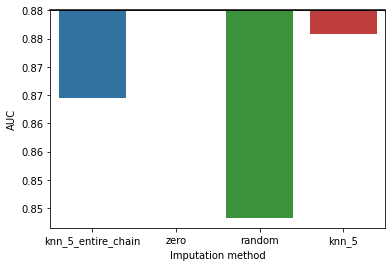

In [69]:
# plot the same using seaborn
import matplotlib.pyplot as plt
import seaborn as sns

baseline = scores['zero']

diff = [scores[score] - baseline for score in scores]
graph = sns.barplot(x=list(scores.keys()), y=diff)

# draw a horizontal line at y=baseline and label it
graph.axhline(0, color="k", clip_on=False)

# graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

y_ticks = graph.get_yticks()
graph.set_yticklabels([f"{baseline+y:.2f}" for y in y_ticks])

graph.set_ylabel("AUC")
graph.set_xlabel("Imputation method")

plt.show()

In [70]:
scores

{'knn_5_entire_chain': 0.8650643068188403,
 'zero': 0.880513875210011,
 'random': 0.8438408840739239,
 'knn_5': 0.8762810671455883}

In [74]:
scores1 = {'knn_5_entire_chain': 0.8650643068188403,
 'zero': 0.880513875210011,
 'random': 0.8438408840739239,
 'knn_5': 0.8762810671455883}

Zero imputation is strangely still the best. However, I didn't do cross validation, so this might not be the best way to evaluate the imputation methods. Let's try generating the scores again, but on another random seed, to see if the results are similar. (note: this is not the way you should do "cross validation", but it's a quick way to see if the results are similar)

In [71]:
from sklearn.ensemble import RandomForestClassifier
from util import evaluate_no_cv

clf = RandomForestClassifier(random_state=42)

scores = dict()
for model in models_to_eval:
    print(f"Evaluating {model['name']}")

    train_x = model['train']
    test_x = model['test']

    # assert no nans
    # print columns containing nans in train
    if not isinstance(train_x, np.ndarray):
        nan_rows = train_x.columns[train_x.isna().any()].tolist()
        if nan_rows:
            print(f"Warning: train has nans in columns: {nan_rows}")
            train_x = train_x.fillna(0)
    if not isinstance(test_x, np.ndarray):
        nan_rows = test_x.columns[test_x.isna().any()].tolist()
        if nan_rows:
            print(f"Warning: test has nans in columns: {nan_rows}")
            test_x = test_x.fillna(0)

    assert not np.isnan(train_x).any().any(), "Nans in train"
    assert not np.isnan(test_x).any().any(), "Nans in test"

    auc = evaluate_no_cv(clf, train_x, df_train_y, test_x, df_test_y)

    scores[model['name']] = auc

Evaluating knn_5_entire_chain
ROC AUC: 0.860
Evaluating zero
ROC AUC: 0.885
Evaluating random
ROC AUC: 0.847
Evaluating knn_5
ROC AUC: 0.882


C:\Users\arnod\AppData\Local\Temp/ipykernel_17524/1456528804.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_yticklabels([f"{baseline+y:.2f}" for y in y_ticks])


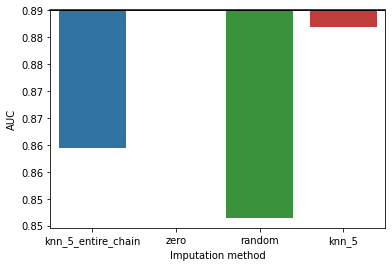

In [85]:
# plot the same using seaborn
import matplotlib.pyplot as plt
import seaborn as sns

def plot_scores(scores, baseline_name):

    baseline = scores[baseline_name]

    diff = [scores[score] - baseline for score in scores]
    graph = sns.barplot(x=list(scores.keys()), y=diff)

    # draw a horizontal line at y=baseline and label it
    graph.axhline(0, color="k", clip_on=False)

    # graph.set_xticklabels(graph.get_xticklabels(), rotation=90)

    y_ticks = graph.get_yticks()
    graph.set_yticklabels([f"{baseline+y:.2f}" for y in y_ticks])

    graph.set_ylabel("AUC")
    graph.set_xlabel("Imputation method")

    plt.show()

    # clear the graph for future plots
    plt.clf()

plot_scores(scores, 'zero')

In [77]:
scores2 = {'knn_5_entire_chain': 0.8597148195353688,
 'zero': 0.8852825734314351,
 'random': 0.8467926249927582,
 'knn_5': 0.882166444586061}

{'knn_5_entire_chain': 0.8597148195353688,
 'zero': 0.8852825734314351,
 'random': 0.8467926249927582,
 'knn_5': 0.882166444586061}

In [75]:
score_diffs = {
    'zero': scores['zero'] - scores1['zero'],
    'random': scores['random'] - scores1['random'],
    'knn_5': scores['knn_5'] - scores1['knn_5'],
    'knn_5_entire_chain': scores['knn_5_entire_chain'] - scores1['knn_5_entire_chain']
}

In [76]:
score_diffs

{'zero': 0.004768698221424117,
 'random': 0.0029517409188343224,
 'knn_5': 0.005885377440472683,
 'knn_5_entire_chain': -0.00534948728347151}

The random seed of the model doesn't seem to make a real difference (but the test set, which remained the same for now) might of course

## Test without NaNs

In [80]:
def fix_test(x_test, train_columns):
    # x_test.fillna(0, inplace=True)
    for col in train_columns:
        if col not in x_test.columns:
            # only columns starting with pos_0 are allowed to be missing, the rest should already exist (be sure you use the test version of the onehot encoder if this isn't the case)
            assert col.startswith('alfa_pos_') or col.startswith('beta_pos_') or col.endswith(
                '_count') or col in ['beta_J', 'beta_V', 'alfa_J','alfa_V'], f'Column {col} not in test set' # Don't know whether col in ['beta_J', 'beta_V', 'alfa_J','alfa_V'] should be aloowed, was required for alpha beta knn

            x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing
            # print(f'Column {col} not in test set, added with NaN values')
    # remove all columns from x_test that are not in x
    x_test = x_test[train_columns]
    return x_test


In [82]:
from sklearn.ensemble import RandomForestClassifier
from util import evaluate_no_cv

df_train_x = get_features(df_train)

df_test_no_nans = df_test.dropna()
df_test_y_no_nans = df_test_no_nans['reaction']
df_test_x_no_nans = get_features(df_test_no_nans, test=True)
df_test_x_no_nans = fix_test(df_test_x_no_nans, df_train_x.columns)

clf = RandomForestClassifier(random_state=42)

scores = dict()
for model in models_to_eval:
    print(f"Evaluating {model['name']}")

    train_x = model['train']

    # assert no nans
    # print columns containing nans in train
    if not isinstance(train_x, np.ndarray):
        nan_rows = train_x.columns[train_x.isna().any()].tolist()
        if nan_rows:
            print(f"Warning: train has nans in columns: {nan_rows}")
            train_x = train_x.fillna(0)

    fixed_test_x = fix_test(df_test_x_no_nans, train_x.columns)

    assert not np.isnan(train_x).any().any(), "Nans in train"

    auc = evaluate_no_cv(clf, train_x, df_train_y, fixed_test_x, df_test_y_no_nans)

    scores[model['name']] = auc

C:\Users\arnod\AppData\Local\Temp/ipykernel_17524/1609111914.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


Evaluating knn_5_entire_chain
ROC AUC: 0.941
Evaluating zero
ROC AUC: 0.950
Evaluating random
ROC AUC: 0.942
Evaluating knn_5


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

Let's skip knn_5 (since it's already an numpy array, which makes it harder to fix the test)

In [87]:
scores_na_1 = {'knn_5_entire_chain': 0.9410718316854034,
 'zero': 0.9497810284888708,
 'random': 0.9422908483452979}

C:\Users\arnod\AppData\Local\Temp/ipykernel_17524/1456528804.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_yticklabels([f"{baseline+y:.2f}" for y in y_ticks])


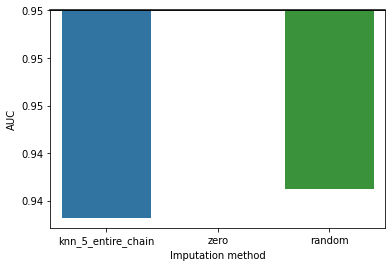

In [88]:
plot_scores(scores_na_1, 'zero')

Strangely, here it makes almost no difference.

## Different number of neighbors


In [107]:
from util import get_train_dataset, get_features, fix_test, get_columns_starting_with
from sklearn.model_selection import train_test_split

df = get_train_dataset() #.sample(200)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

df_test = df_test.dropna()

df_train_y = df_train['reaction']
df_test_y = df_test['reaction']

df_train_x = get_features(df_train)
df_test_x = get_features(df_test, test=True)
df_test_x = fix_test(df_test_x, df_train_x.columns)

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = 0 #np.nan  # TODO: NaN of 0? currently kept it at 0 to make clear it's not because the chain was missing


In [108]:
from sklearn.neighbors import NearestNeighbors

df_both_alpha_and_beta = df_train[df_train['CDR3_alfa'].notna() & df['CDR3_beta'].notna()]
features_complete_samples = get_features(df_both_alpha_and_beta)

alfa_rows = get_columns_starting_with(features_complete_samples, 'alfa_')
beta_rows = get_columns_starting_with(features_complete_samples, 'beta_')

_, _, common_columns_alfa, common_columns_beta = get_nnbrs_parameters(df_train_x, full=False)

C:\Users\arnod\AppData\Local\Temp/ipykernel_17524/2302238783.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_both_alpha_and_beta = df_train[df_train['CDR3_alfa'].notna() & df['CDR3_beta'].notna()]


In [110]:
scores = dict()
for n_neighbors in [1, 3, 5, 10, 20, 50]:
    print(f"Testing {n_neighbors}")

    alfa_search_space = alfa_rows[common_columns_alfa]
    beta_search_space = beta_rows[common_columns_beta]

    nnbrs_alfa = NearestNeighbors(n_neighbors=n_neighbors).fit(alfa_search_space)
    nnbrs_beta = NearestNeighbors(n_neighbors=n_neighbors).fit(beta_search_space)

    knn_imputed_train = knn_fill_df(df_train_x, nnbrs_alfa, nnbrs_beta, alfa_rows, beta_rows, common_columns_alfa, common_columns_beta)

    print(f"Nan rows: {knn_imputed_train.columns[knn_imputed_train.isna().any()].tolist()}")
    knn_imputed_train = knn_imputed_train.fillna(0)

    auc = evaluate_no_cv(clf, knn_imputed_train, df_train_y, df_test_x, df_test_y)

    scores[n_neighbors] = auc

Testing 1


100%|██████████| 6645/6645 [01:16<00:00, 87.35it/s] 


Nan rows: ['beta_J', 'beta_V', 'alfa_J', 'alfa_V']
ROC AUC: 0.936
Testing 3


100%|██████████| 6645/6645 [01:17<00:00, 85.19it/s] 


Nan rows: ['beta_J', 'beta_V', 'alfa_J', 'alfa_V']
ROC AUC: 0.944
Testing 5


100%|██████████| 6645/6645 [01:17<00:00, 86.28it/s] 


Nan rows: ['beta_J', 'beta_V', 'alfa_J', 'alfa_V']
ROC AUC: 0.941
Testing 10


100%|██████████| 6645/6645 [01:16<00:00, 86.33it/s] 


Nan rows: ['beta_J', 'beta_V', 'alfa_J', 'alfa_V']
ROC AUC: 0.943
Testing 20


100%|██████████| 6645/6645 [01:23<00:00, 79.86it/s] 


Nan rows: ['beta_J', 'beta_V', 'alfa_J', 'alfa_V']
ROC AUC: 0.944
Testing 50


100%|██████████| 6645/6645 [01:18<00:00, 84.61it/s] 


Nan rows: ['beta_J', 'beta_V', 'alfa_J', 'alfa_V']
ROC AUC: 0.950


In [111]:
scores

{1: 0.9363628154769967,
 3: 0.9435956476590366,
 5: 0.9410718316854034,
 10: 0.9429229310578355,
 20: 0.9440561650638856,
 50: 0.9502415458937199}

C:\Users\arnod\AppData\Local\Temp/ipykernel_17524/1456528804.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_yticklabels([f"{baseline+y:.2f}" for y in y_ticks])


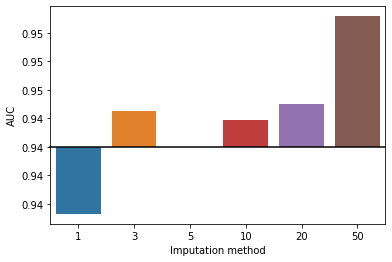

In [112]:
# graph.clf()
plot_scores(scores, 5)

Result are the opposite of what I expected. I would expect that increasing the n in knn  would decrease the AUC from a certain value (e.g. start decreasing from n=5). Let's try some other larger values.
Also here, note that I didn't use cross validation, so this might influence our results.
There are only 666 test samples.

In [113]:
for n_neighbors in [150, 300, 600]:
    print(f"Testing {n_neighbors}")

    alfa_search_space = alfa_rows[common_columns_alfa]
    beta_search_space = beta_rows[common_columns_beta]

    nnbrs_alfa = NearestNeighbors(n_neighbors=n_neighbors).fit(alfa_search_space)
    nnbrs_beta = NearestNeighbors(n_neighbors=n_neighbors).fit(beta_search_space)

    knn_imputed_train = knn_fill_df(df_train_x, nnbrs_alfa, nnbrs_beta, alfa_rows, beta_rows, common_columns_alfa, common_columns_beta)

    print(f"Nan rows: {knn_imputed_train.columns[knn_imputed_train.isna().any()].tolist()}")
    knn_imputed_train = knn_imputed_train.fillna(0)

    auc = evaluate_no_cv(clf, knn_imputed_train, df_train_y, df_test_x, df_test_y)

    scores[n_neighbors] = auc

Testing 150


100%|██████████| 6645/6645 [01:27<00:00, 76.27it/s] 


Nan rows: ['beta_J', 'beta_V', 'alfa_J', 'alfa_V']
ROC AUC: 0.945
Testing 300


100%|██████████| 6645/6645 [01:35<00:00, 69.29it/s] 


Nan rows: ['beta_J', 'beta_V', 'alfa_J', 'alfa_V']
ROC AUC: 0.951
Testing 600


100%|██████████| 6645/6645 [01:38<00:00, 67.65it/s] 


Nan rows: ['beta_J', 'beta_V', 'alfa_J', 'alfa_V']
ROC AUC: 0.947


C:\Users\arnod\AppData\Local\Temp/ipykernel_17524/1456528804.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_yticklabels([f"{baseline+y:.2f}" for y in y_ticks])


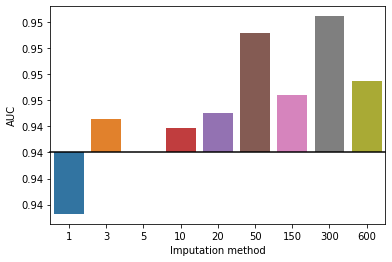

In [114]:
plot_scores(scores, 5)

All results in similar range.